<a href="https://colab.research.google.com/github/Chdunham/DunhamResearchCode/blob/main/SyntheticUndersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get Adult data from UCI repository: https://archive.ics.uci.edu/ml/datasets/adult
# >50K, <=50K.
# age: continuous.
#workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

#@title Import Information
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn.preprocessing as preprocessing

tf.__version__

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")


Ran the import statements.


In [ ]:
# Source: https://fairmlbook.org/code/adult.html

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

# Drop Na values in train and test sets
original_train = original_train.dropna()
original_test = original_test.dropna()


original = pd.concat([original_train, original_test])
# original = pd.concat([original, toriginal])
roc_original = original

original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [ ]:
Variable_scale = 1600

Mask = (original['Sex'] == 'Male') & ((original['Target'] == '<=50K') | (original['Target'] == '<=50K.'))
LessMale = original[Mask]

Mask = (original['Sex'] == 'Male') & ((original['Target'] == '>50K') | (original['Target'] == '>50K.'))
MoreMale = original[Mask]

Mask = (original['Sex'] == 'Female') & ((original['Target'] == '<=50K') | (original['Target'] == '<=50K.'))
LessFemale = original[Mask]

Mask = (original['Sex'] == 'Female') & ((original['Target'] == '>50K') | (original['Target'] == '>50K.'))
MoreFemale = original[Mask]

original = pd.concat([LessMale[:Variable_scale],\
                      MoreMale[:Variable_scale], \
                      LessFemale[:Variable_scale], MoreFemale[:Variable_scale]])
original = original.sample(frac=1)
original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
4526,47,Private,73064,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,35,United-States,<=50K
3083,28,Private,169069,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5692,31,Private,79190,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,35,United-States,<=50K
4020,37,Private,89559,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
3628,22,Private,203182,Bachelors,13,Never-married,Exec-managerial,Other-relative,White,Female,0,0,20,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,30,Private,110643,Masters,14,Married-civ-spouse,Adm-clerical,Husband,White,Male,4386,0,40,United-States,>50K
4074,33,Private,254221,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
2741,47,State-gov,189123,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
2340,30,Private,100734,Bachelors,13,Married-civ-spouse,Exec-managerial,Other-relative,White,Female,0,0,40,Greece,>50K.


In [ ]:
original = original.sample(frac=1)

original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
346,39,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999,0,40,United-States,>50K.
593,31,Private,168387,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,Canada,>50K
7271,28,Private,132686,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
7269,33,Private,101352,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
11443,46,Self-emp-inc,167882,Assoc-voc,11,Divorced,Exec-managerial,Not-in-family,White,Female,8614,0,70,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,49,Self-emp-inc,362654,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,50,United-States,>50K
251,42,Private,390781,Bachelors,13,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,40,United-States,<=50K
2949,31,Private,186787,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,42,United-States,<=50K
3234,34,Private,235124,HS-grad,9,Never-married,Other-service,Unmarried,Black,Female,0,0,35,United-States,<=50K


In [ ]:
Synthetic_data = pd.read_csv('/content/Gen_sampleTransform3.csv')
Synthetic_data = Synthetic_data.drop(['Unnamed: 0', 'Age'], axis = 1)
Synthetic_data

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Target,Capital Gain,Capital Loss,Hours per week
0,Private,Assoc-voc,Never-married,Exec-managerial,Husband,White,Male,United-States,NaN,1.0,-0.0,11.0
1,Self-emp-inc,Assoc-voc,Married-civ-spouse,Exec-managerial,Unmarried,Other,Female,Trinadad&Tobago,<=50K,1.0,1.0,8.0
2,Self-emp-inc,Assoc-voc,Never-married,Craft-repair,Husband,White,Male,United-States,NaN,-0.0,-0.0,11.0
3,Private,Bachelors,Married-spouse-absent,Exec-managerial,Not-in-family,Other,Female,Trinadad&Tobago,<=50K,1.0,1.0,10.0
4,Self-emp-inc,Assoc-voc,Married-civ-spouse,Exec-managerial,Own-child,Other,Female,Trinadad&Tobago,<=50K,1.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Self-emp-inc,Assoc-voc,Married-civ-spouse,Exec-managerial,Own-child,Other,Female,Trinadad&Tobago,<=50K,1.0,1.0,8.0
996,Self-emp-inc,Assoc-voc,Never-married,Craft-repair,Husband,White,Male,United-States,NaN,-0.0,-0.0,11.0
997,Self-emp-inc,Assoc-voc,Married-civ-spouse,Exec-managerial,Unmarried,Other,Female,Trinadad&Tobago,<=50K,1.0,1.0,8.0
998,Self-emp-not-inc,Assoc-voc,Married-AF-spouse,Craft-repair,Wife,White,NaN,United-States,NaN,-0.0,-0.0,9.0


In [ ]:
num_train = int(len(original) *.666)

train_data = original[:num_train]
test_data = original[num_train:]

train_data

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
346,39,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999,0,40,United-States,>50K.
593,31,Private,168387,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,Canada,>50K
7271,28,Private,132686,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
7269,33,Private,101352,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
11443,46,Self-emp-inc,167882,Assoc-voc,11,Divorced,Exec-managerial,Not-in-family,White,Female,8614,0,70,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,56,Private,174351,12th,8,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Italy,<=50K
2921,23,Private,238917,7th-8th,4,Never-married,Craft-repair,Other-relative,White,Male,0,0,36,United-States,<=50K
2068,37,Private,86150,Bachelors,13,Married-civ-spouse,Other-service,Wife,Asian-Pac-Islander,Female,0,0,30,United-States,>50K
2178,37,Private,201531,Assoc-acdm,12,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K


In [ ]:
import random

Mask = (Synthetic_data['Sex'] == 'Male') & ((Synthetic_data['Target'] == '<=50K') | (Synthetic_data['Target'] == '<=50K.'))

LessMale = Synthetic_data[Mask]

#20988
#print(LessMale.describe())

Mask = (Synthetic_data['Sex'] == 'Male') & ((Synthetic_data['Target'] == '>50K') | (Synthetic_data['Target'] == '>50K.'))
MoreMale = Synthetic_data[Mask]
#9539
#print(MoreMale.describe())

Mask = (Synthetic_data['Sex'] == 'Female') & ((Synthetic_data['Target'] == '<=50K') | (Synthetic_data['Target'] == '<=50K.'))
LessFemale = Synthetic_data[Mask]
#13026
#print(LessFemale.describe())

Mask = (Synthetic_data['Sex'] == 'Female') & ((Synthetic_data['Target'] == '>50K') | (Synthetic_data['Target'] == '>50K.'))
MoreFemale = Synthetic_data[Mask]
#1669
#print(MoreFemale.describe())

Mask = (train_data['Sex'] == 'Male') & ((train_data['Target'] == '<=50K') | (train_data['Target'] == '<=50K.'))
originalLessMale = train_data[Mask]

Mask = (train_data['Sex'] == 'Male') & ((train_data['Target'] == '>50K') | (train_data['Target'] == '>50K.'))
originalMoreMale = train_data[Mask]

Mask = (train_data['Sex'] == 'Female') & ((train_data['Target'] == '<=50K') | (train_data['Target'] == '<=50K.'))
originalLessFemale = train_data[Mask]

Mask = (train_data['Sex'] == 'Female') & ((train_data['Target'] == '>50K') | (train_data['Target'] == '>50K.'))
originalMoreFemale = train_data[Mask]

print(len(originalLessMale), len(originalMoreMale), len(originalLessFemale), len(originalMoreFemale))

1082 1062 1044 1074


In [ ]:

train_data = train_data.drop(['fnlwgt', 'Education-Num'], axis = 1)

train_data = pd.concat([originalLessMale, originalMoreMale, originalLessFemale, originalMoreFemale])
train_data = train_data.sample(frac=1)

train_data

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
4462,38,Private,312766,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K.
3070,27,Private,301654,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
10346,33,Private,187802,Bachelors,13,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,1887,40,United-States,>50K.
8824,58,Private,372181,HS-grad,9,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States,>50K
434,27,Private,116358,Some-college,10,Never-married,Craft-repair,Own-child,Asian-Pac-Islander,Male,0,1980,40,Philippines,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,41,Self-emp-inc,94113,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
2567,24,State-gov,166851,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,13,United-States,<=50K
3487,44,Private,54507,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K
4632,59,Private,107833,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,1485,40,United-States,>50K


In [ ]:
#@title Preprocess data into specific values

# Redundant column
train_labels = train_data['Target']
train_labels = train_labels.replace('<=50K', 0).replace('>50K', 1)
train_labels = train_labels.replace('<=50K.', 0).replace('>50K.', 1)

test_labels = test_data['Target']
test_labels = test_labels.replace('<=50K', 0).replace('>50K', 1)
test_labels = test_labels.replace('<=50K.', 0).replace('>50K.', 1)

train_data.drop(['Target','fnlwgt', 'Education-Num'], axis = 1, inplace = True)
test_data.drop(['Target','fnlwgt', 'Education-Num'], axis = 1, inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
""
#@title Continue to preprocess Data 

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

train_data = data_transform(train_data)

test_data = data_transform(test_data)



In [ ]:
for x in test_data.columns:
    if x not in train_data.columns:
      test_data.drop(x, axis = 1, inplace = True)
      print(x)


for x in train_data.columns:
    if x not in test_data.columns:
      train_data.drop(x, axis = 1, inplace = True)
      print(x)


train_data

Country_Hungary
Country_Thailand
Workclass_Without-pay
Country_Haiti
Country_Hong
Country_Laos
Country_Nicaragua
Country_Outlying-US(Guam-USVI-etc)
Country_Peru
Country_Scotland


,Age,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,...,Country_Japan,Country_Mexico,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_South,Country_Taiwan,Country_Trinadad&Tobago,Country_United-States
0,-0.2,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
1,-1.0,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2,-0.6,-0.2,3.7,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
3,1.5,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4,-1.0,-0.2,3.9,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,12.3,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,0.1,-0.2,-0.3,1.6,-0.2,-0.3,-1.6,4.7,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4258,-1.3,-0.2,-0.3,-2.4,-0.2,-0.3,-1.6,-0.2,-0.3,4.7,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4259,0.3,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4260,1.6,-0.2,2.8,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3


In [ ]:
new_df = test_labels
temp = new_df.reset_index()
test = test_data.reset_index()
test = test.drop(['index'], axis = 1)
test_data = test
# test_data['Target'] = temp['Target']

test_data

,Age,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,...,Country_Japan,Country_Mexico,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_South,Country_Taiwan,Country_Trinadad&Tobago,Country_United-States
0,-0.8,-0.2,-0.3,-0.1,5.1,-0.3,-1.5,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
1,1.9,-0.2,-0.3,-2.6,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2,0.3,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
3,-0.4,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4,-0.3,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,0.7,1.4,-0.3,0.8,-0.2,-0.3,-1.5,4.9,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2134,0.2,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2135,-0.7,-0.2,-0.3,0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2136,-0.5,-0.2,-0.3,-0.5,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.1,-0.0,-0.1,-0.0,-0.0,-0.0,0.3


In [ ]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
'''
temp = tf.feature_column.numeric_column("Sex_Male")
feature_columns.append(temp)

temp = tf.feature_column.numeric_column("Sex_Female")
feature_columns.append(temp)
'''
for x in train_data.columns:
  if x != 'Target':
    temp = tf.feature_column.numeric_column(x)
    feature_columns.append(temp)

print(feature_columns)
# Convert the list of feature columns into a layer that will later be fed into
# the model. 

feature_layer = layers.DenseFeatures(feature_columns)
# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:

feature_layer(dict(train_data))

[NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Capital Gain', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Capital Loss', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Hours per week', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Workclass_Federal-gov', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Workclass_Local-gov', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Workclass_Private', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Workclass_Self-emp-inc', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Workclass_Self-emp-not-inc', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(ke

<tf.Tensor: shape=(4262, 89), dtype=float32, numpy=
array([[-0.15189272, -0.19736467, -0.25836056, ..., -0.21059884,
        -0.2925462 , -0.21421851],
       [-1.0458212 , -0.19736467, -0.25836056, ..., -0.21059884,
        -0.2925462 , -0.21421851],
       [-0.55822384, -0.19736467,  3.6688747 , ..., -0.21059884,
        -0.2925462 , -0.21421851],
       ...,
       [ 0.33570465, -0.19736467, -0.25836056, ..., -0.21059884,
        -0.2925462 , -0.21421851],
       [ 1.554698  , -0.19736467,  2.83223   , ..., -0.21059884,
        -0.2925462 , -0.21421851],
       [ 1.0671006 , -0.19736467, -0.25836056, ..., -0.21059884,
        -0.2925462 , -0.21421851]], dtype=float32)>

In [ ]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = Sequential()

  model.add(Dense(100, activation='relu', input_shape=(test_data.shape[1],)))

  model.add(Dense(75, activation='relu'))

  model.add(Dense(50, activation='relu'))

  #model.add(Dense(50, activation='relu'))

  model.add(Dense(25, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model       


def train_model(model, dataset, epochs,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  #features = {name:np.array(value) for name, value in dataset.items()}
  #label = np.array(features.pop(label_name)) 


  history = model.fit(x=train_data, y=train_labels, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_split=0.1)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [ ]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/50
10/10 [==============================] - 4s 155ms/step - loss: 0.6859 - accuracy: 0.6636 - precision: 0.6791 - recall: 0.6255 - auc: 0.7215 - True Positives: 1204.0000 - False Positives: 569.0000 - True Negative: 1341.0000 - False Negatives: 721.0000 - val_loss: 0.4929 - val_accuracy: 0.7775 - val_precision: 0.6986 - val_recall: 0.9668 - val_auc: 0.8880 - val_True Positives: 204.0000 - val_False Positives: 88.0000 - val_True Negative: 128.0000 - val_False Negatives: 7.0000
Epoch 2/50
10/10 [==============================] - 0s 15ms/step - loss: 0.4150 - accuracy: 0.8081 - precision: 0.7777 - recall: 0.8649 - auc: 0.8908 - True Positives: 1665.0000 - False Positives: 476.0000 - True Negative: 1434.0000 - False Negatives: 260.0000 - val_loss: 0.4072 - val_accuracy: 0.8150 - val_precision: 0.8300 - val_recall: 0.7867 - val_auc: 0.9007 - val_True Positives: 166.0000 - val_False Positives: 34.0000 - val_True Negative: 182.0000 - val_False Negatives: 45.0000
Epoch 3/50
10/10 [====

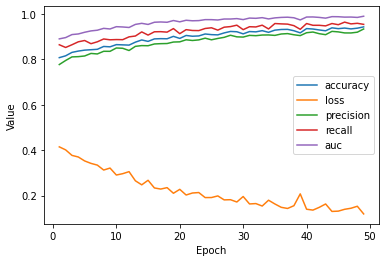

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 1e-2
epochs = 50
batch_size = 400
label_name = "Target"
classification_threshold = 0.50
 
# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
           
           tf.keras.metrics.AUC(num_thresholds=100, name='auc'),

           tf.keras.metrics.TruePositives(thresholds=classification_threshold, name='True Positives'),

           tf.keras.metrics.FalsePositives(thresholds=classification_threshold, name='False Positives'),

           tf.keras.metrics.TrueNegatives(thresholds=classification_threshold, name='True Negative'),

           tf.keras.metrics.FalseNegatives(thresholds=classification_threshold, name='False Negatives')
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_data, epochs, batch_size)

print(hist.columns)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'loss', 'precision', 'recall', 'auc'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)


In [ ]:
train_data

,Age,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,...,Country_Japan,Country_Mexico,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_South,Country_Taiwan,Country_Trinadad&Tobago,Country_United-States
0,-0.2,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
1,-1.0,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
2,-0.6,-0.2,3.7,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
3,1.5,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4,-1.0,-0.2,3.9,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,12.3,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,0.1,-0.2,-0.3,1.6,-0.2,-0.3,-1.6,4.7,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4258,-1.3,-0.2,-0.3,-2.4,-0.2,-0.3,-1.6,-0.2,-0.3,4.7,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4259,0.3,-0.2,-0.3,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3
4260,1.6,-0.2,2.8,-0.1,-0.2,-0.3,0.6,-0.2,-0.3,-0.2,...,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.0,0.3


Test Accuracy: 0.7890551917680075
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1074
           1       0.77      0.83      0.80      1064

    accuracy                           0.79      2138
   macro avg       0.79      0.79      0.79      2138
weighted avg       0.79      0.79      0.79      2138



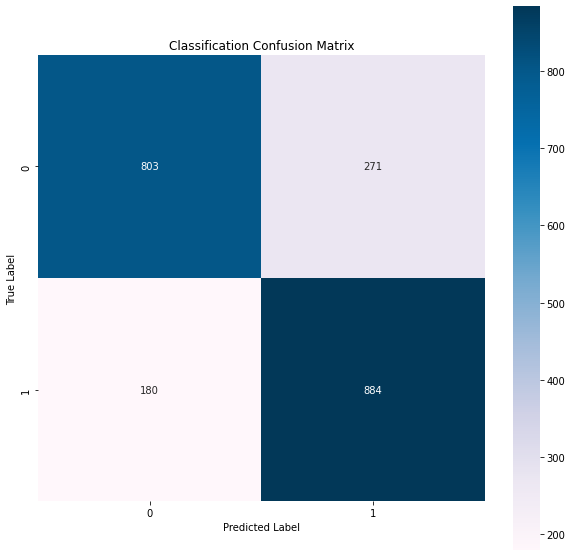

In [ ]:
import seaborn as sns

import pandas as pd

 

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

Xtemp = test_data.values
ypred = my_model(Xtemp)

# Convert the predictions from tensor to numpy arraay

ypred = ypred.numpy()

y_test = test_labels

# Convert the values to zeros and ones

ypred = [1 if cy >= 0.5 else 0 for cy in ypred]

 

acc = np.sum(ypred == y_test)/len(y_test)

print('Test Accuracy:', acc)

 

print(classification_report(y_test, ypred))

 

cm = confusion_matrix(y_test, ypred)

 

plt.figure(figsize=(10, 10))

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

 

plt.xlabel('Predicted Label');

plt.ylabel('True Label')

plt.title('Classification Confusion Matrix')

plt.show()

ypred = np.array(ypred)

In [ ]:
test_data['Sex_Male']

0       1.0
1      -1.0
2      -1.0
3      -1.0
4       1.0
       ... 
2133    1.0
2134   -1.0
2135    1.0
2136   -1.0
2137   -1.0
Name: Sex_Male, Length: 2138, dtype: float64

0      1.0
4      1.0
5      1.0
6      1.0
10     1.0
        ..
2127   1.0
2129   1.0
2132   1.0
2133   1.0
2135   1.0
Name: Sex_Male, Length: 1056, dtype: float64


0      1.0
1      0.0
2      0.0
3      0.0
4      1.0
        ..
2133   1.0
2134   0.0
2135   1.0
2136   0.0
2137   0.0
Name: Sex_Male, Length: 2138, dtype: float64

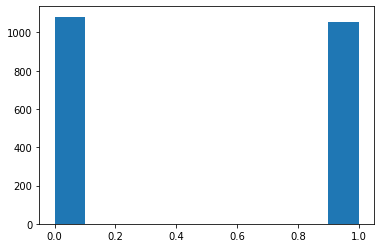

In [ ]:
sensitive = test_data['Sex_Male'].copy()
mask = abs(sensitive - 0.7) < 0.5

print(sensitive[mask])

sensitive[mask] = 1
sensitive[~mask] = 0

plt.hist(sensitive)

sensitive


In [ ]:
ypred

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
mask_s0 = sensitive == 0
mask_s1 = sensitive == 1
mask_ypred1 = ypred == 1


In [ ]:

count_0 = np.sum(mask_s0 & mask_ypred1)
count_1 = np.sum(mask_s1 & mask_ypred1)

print(count_0, count_1)

prob0 = count_0 / np.sum(mask_s0)
prob1 = count_1 / np.sum(mask_s1)
demo_par_diff = prob1 - prob0

print('P(ypred=1 | s=0): {:.4f}'.format(prob0)) # high income given female
print('P(ypred=1 | s=1): {:.4f}'.format(prob1)) # high income given male
print('Demographic Parity Score: {:.4f}'.format(demo_par_diff)) #Parity Gap score -- Gap favors male over female

547 608
P(ypred=1 | s=0): 0.5055
P(ypred=1 | s=1): 0.5758
Demographic Parity Score: 0.0702


In [ ]:
mask_s0 = sensitive == 0
mask_s1 = sensitive == 1
mask_ypred1 = ypred == 1
mask_y0 = y_test == 0
mask_y1 = y_test == 1

# Low income version
count0 = np.sum(mask_s0 & mask_ypred1 & mask_y0)
count1 = np.sum(mask_s1 & mask_ypred1 & mask_y0)
prob0 = count0 / np.sum(mask_s0 & mask_y0)
prob1 = count1 / np.sum(mask_s1 & mask_y0)

print(prob0, prob1)

print('Equality of opportunity score (low income):', prob1 - prob0)

# High income version
count0 = np.sum(mask_s0 & mask_ypred1 & mask_y1)
count1 = np.sum(mask_s1 & mask_ypred1 & mask_y1)
prob0 = count0 / np.sum(mask_s0 & mask_y1)
prob1 = count1 / np.sum(mask_s1 & mask_y1)

print('Equality of opportunity score (high income):', prob1 - prob0)

0.5111111111111111 0.5606694560669456
Equality of opportunity score (low income): 0.049558344955834555
Equality of opportunity score (high income): 0.026458776281596985
